<br><br>
<font size='6'><b>Physics-informed Neural Networks (PINN)
</b></font><br><br>

<br>
<div class=pull-right>
By Prof. Seungchul Lee<br>
http://iailab.kaist.ac.kr/<br>
Industrial AI Lab at KAIST
</div>

Table of Contents
<div id="toc"></div>

# 1. Why Deep Learning Needs Physics?

Why do data-driven ‘black-box’ methods fail?
- May output result that is physically inconsistent
- Easy to learn spurious relationships that look good only on training and test data
    - Can lead to poor generalization outside the available data (out-of-sample prediction tasks)
- Interpretability is absent
    - Discovering the mechanism of an underlying process is crucial for scientific advancements


Physics-Informed Neural Networks (PINNs)
- Take full advantage of data science methods with the accumulated prior knowledge of scientific theories $\rightarrow$ Improve predictive performance
- Integration of domain knowledge to overcome the issue of imbalanced data & data shortage


## 1.1. Taxonomy of Informed Deep Learning



<br>
<center>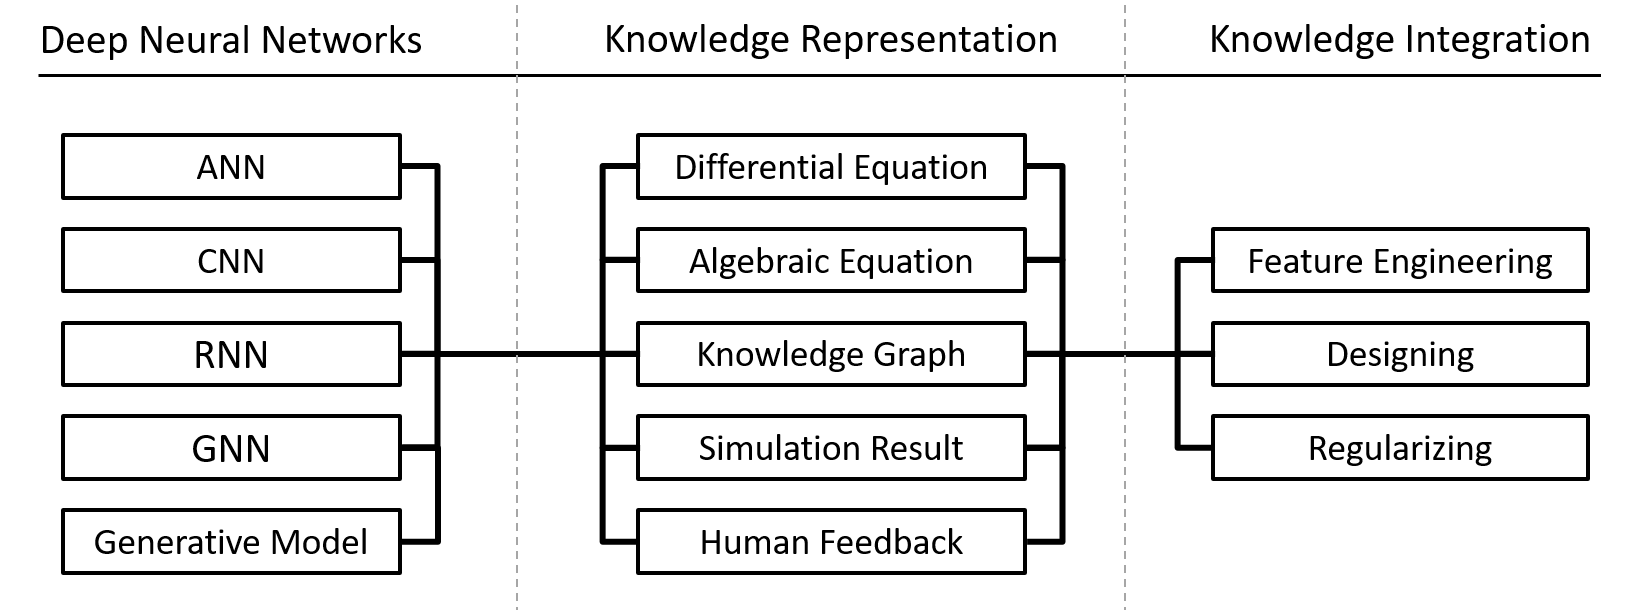</center>
<br>



## 1.2. Multilayer Feedforward Networks are Universal Approximators


- The Universal Approximation Theorem
    - Neural Networks are capable of approximating any Borel measurable function
    - Neural Networks (1989)



<br>
<center>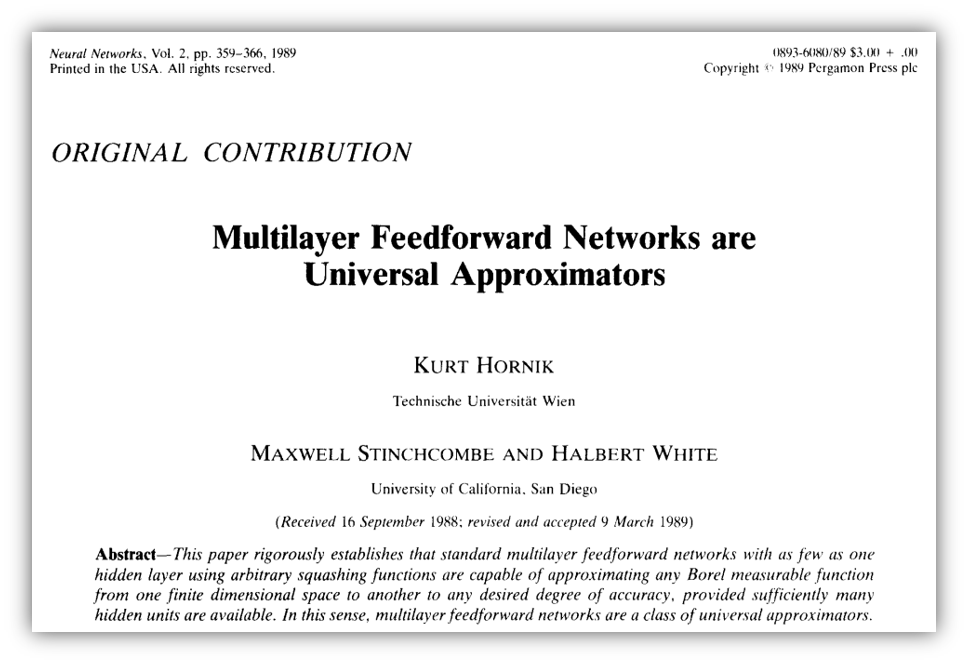</center>
<br>



## 1.3. Neural Networks for Solving Differential Equations

- Neural Algorithm for Solving Differential Equations
    - Journal of Computational Physics (1990)
    - Neural minimization for finite difference equation



<br>
<center>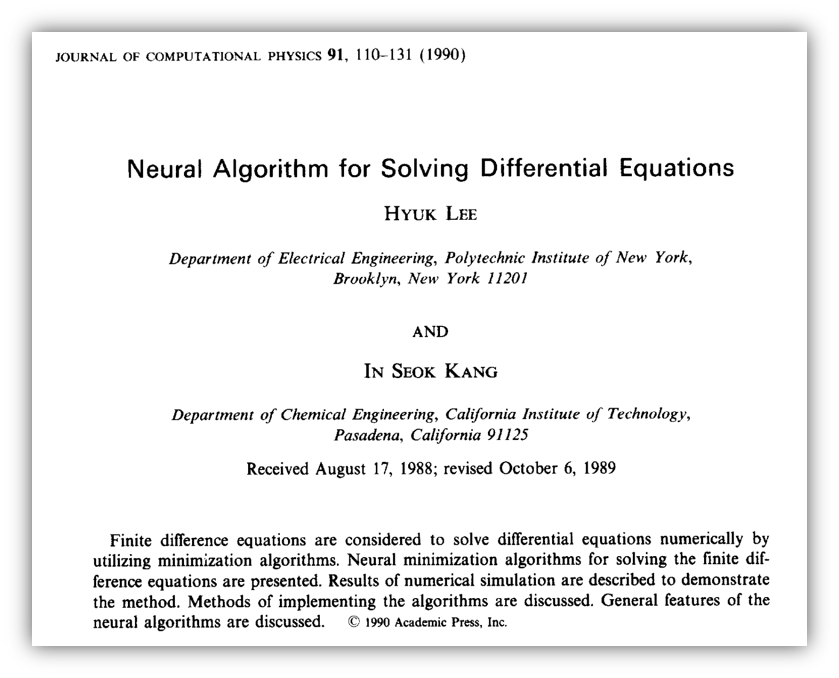</center>
<br>



- ANN for ODE and PDE
    - IEEE on Neural Networks (1998)



<br>
<center>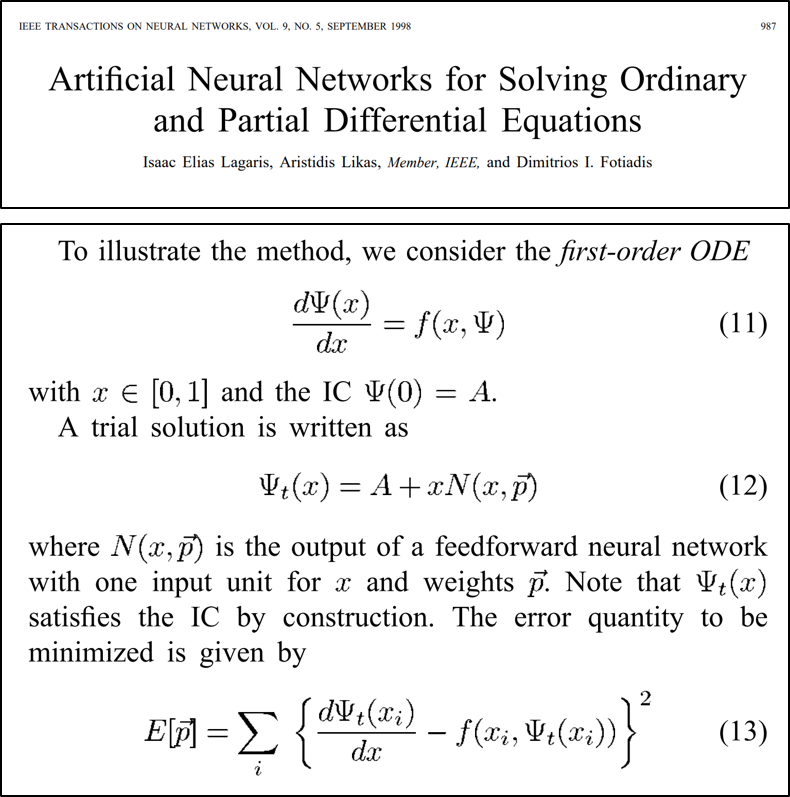</center>
<br>



## 1.4. Journal of Computational Physics (2019)



<br><br>
<center>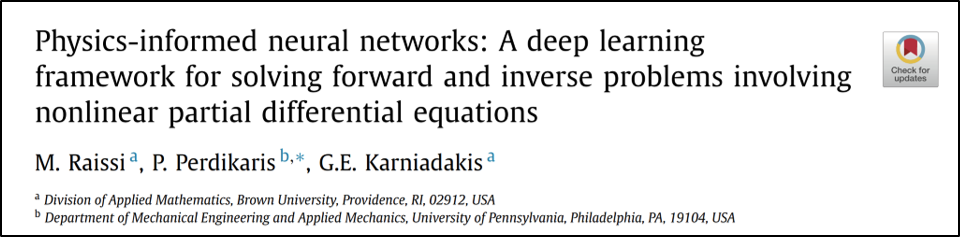</center>
<br>



<br>
<center>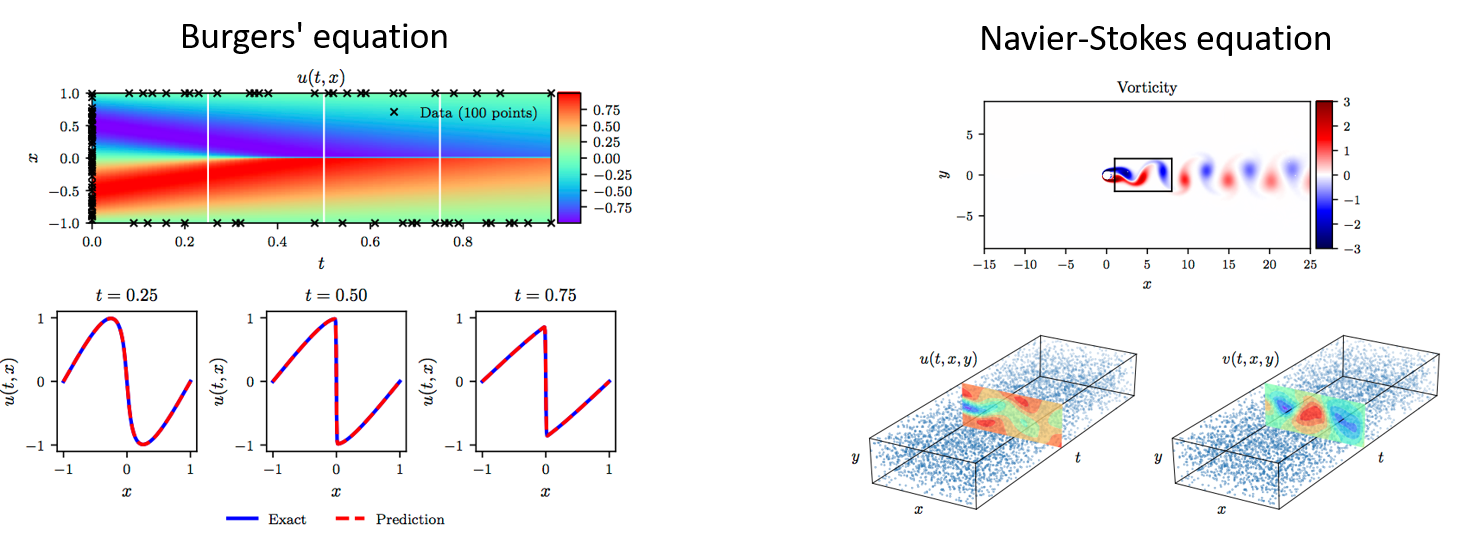</center>
<br>



## 1.5. Nature Reviews Physics (2021)



<br><br>
<center>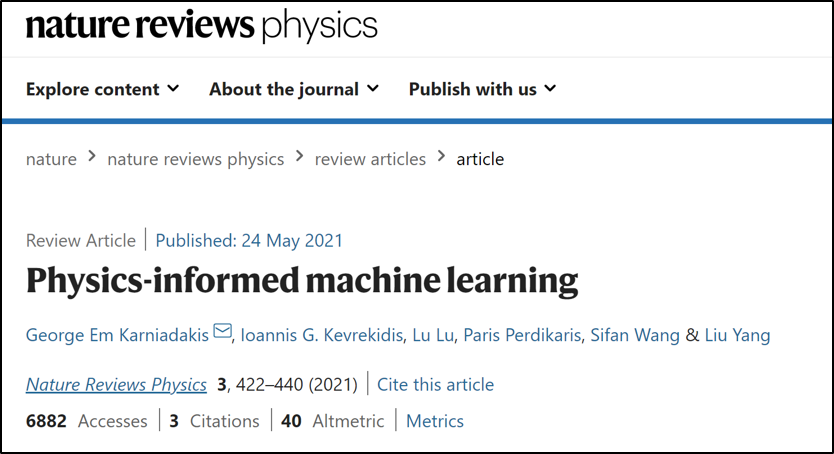</center>
<br>


# 2. Architecture of Physics-informed Neural Networks (PINN)


- NN as an universal function approximator


- Given
    - Some measured data from initial and boundary conditions
    - ODE or PDE

<br>
$$
\frac{\partial u}{\partial t} - \lambda \frac{\partial^2 u}{\partial x^2} = 0
$$
<br>

- Adding constraints for regularization
    - Regularized by physics, but matched with sparse data

<br>
$$
\begin{align*}
\mathcal{L} &= \omega_{\text{data}}  \mathcal{L}_{\text{data}} + \omega_{\text{PDE}} \mathcal{L}_{\text{PDE}}\\\\\\
\mathcal{L}_{\text{data}} &= \frac{1}{N_{\text{data}}} \sum \left(u(x,t) - u \right)^2 \\
\mathcal{L}_{\text{PDE}} &= \frac{1}{N_{\text{PDE}}} \sum \left(\frac{\partial u}{\partial t} - \lambda \frac{\partial^2 u}{\partial x^2} \right)^2
\end{align*}
$$




<br><br>
<center>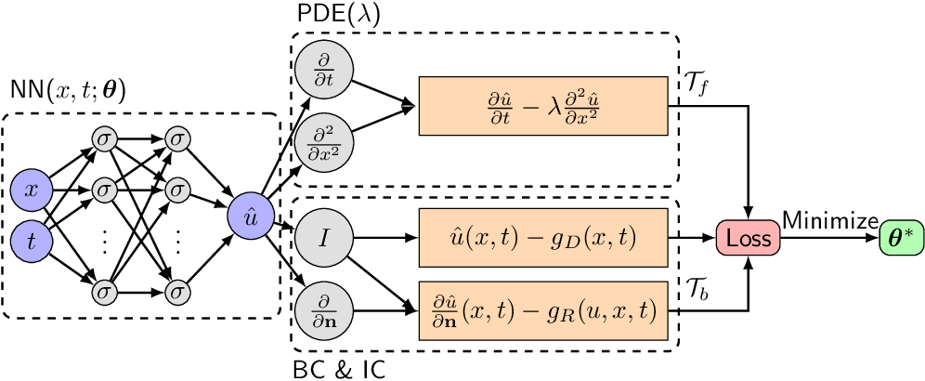</center>
<br>

# 3. Methond for Solving ODE with Neural Networks

## 3.1. Background

[This is a result first due to Lagaris et.al from 1998.](https://arxiv.org/pdf/physics/9705023.pdf) The idea is to solve differential equations using neural networks by representing the solution by a neural network and training the resulting network to satisfy the conditions required by the differential equation.

Consider a system of ordinary differential equations

$$
{u^\prime} = f(u,t)
$$

with $t \in [0, 1]$ and a known initial condition $u(0) = u_0$.

To solve this, we approximate the solution by a neural network:

$$
{\text{NN}(t)} \approx {u(t)}
$$

<br>

If $\text{NN}(t)$ was the true solution, then it would hold that $\text{NN}'(t) = f\left(\text{NN}(t),t \right)$ for all $t$. Thus we turn this condtion into our loss function. This motivates the loss function.

<br>
$${L(\omega)} = \sum_{i} \left(\frac{d \text{NN}(t_i)}{dt}-f\left(\text{NN}(t_i),t_i \right)\right)^2$$
<br>

The choice of $t_i$ could be done in many ways: it can be random, it can be a grid, etc. Anyways, when this loss function is minimized (gradients computed with standard reverse-mode automatic differentiation), then we have that $\frac{dNN(t_i)}{dt} \approx f(\text{NN}(t_i),t_i)$ and thus $\text{NN}(t)$ approximately solves the differential equation.

Note that we still have to handle the initial condition. One simple way to do this is to add an initial condition term to the cost function.

<br>
$${L(\omega)} = \sum_{i} \left(\frac{d \text{NN}(t_i)}{dt}-f(\text{NN}(t_i),t_i)\right)^2 + (\text{NN}(0)-u_0)^2 $$
<br>

where $\omega$ are the parameters that define the neural network $\text{NN}$ that approximates $u$. Thus this reduces down, once again, to simply finding weights which minimize a loss function !

## 3.2. Lab 1: Simple Example

- Let's look at the ODE:

<br>
$$\frac{du}{dt} = \cos2\pi t$$

- Initial condition:

<br>
$$u(0) = 1$$

- The exact solution:

<br>
$$u(t) = \frac{1}{2\pi}\sin2\pi t + 1$$

- Make a neural network and loss functions like below:



<br>
<center>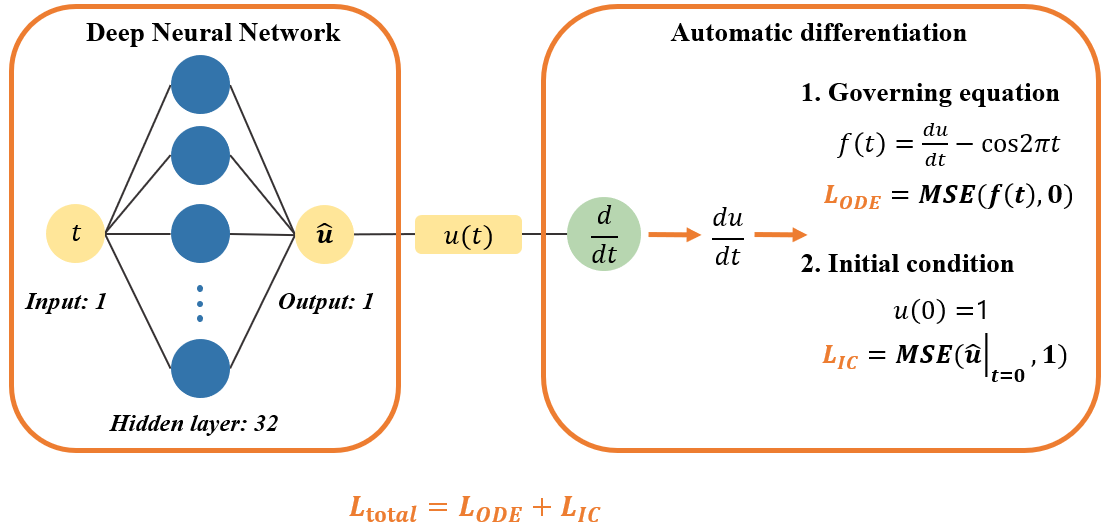</center>
<br>

### 3.2.0. Setup

- Using tensorFlow 2


- **Install and Setup**
    - TensorFlow >= 2.2.0 and TensorFlow Probability >= 0.10.0
    - If you have TensorFlow 2.2.0, TensorFlow Probability == 0.10.0 should be installed  
         (TensorFlow 2.3.0 matches with TensorFlow Probability 0.11.0 and so on)

In [ ]:
# !pip install tensorflow-probability

### 3.2.1. Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

### 3.2.2. Define Network and Hyper-parameters

In [ ]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                64        
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

### 3.2.3. Define ODE System

- ODE loss:

<br>
$$L_{\text{ODE}} = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{d \text{NN}(t_i)}{dt}- \cos2\pi t_i\right)^2$$

- Initial condition loss:

<br>
$$L_{IC} = \frac{1}{n}\sum_{i=1}^{n} \left({\text{NN}(0)}- 1\right)^2$$


- Total loss:

<br>
$$L_{\text{Total}} = L_{\text{ODE}} + L_{\text{IC}}$$

In [ ]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

### 3.2.4. Train & Prediction

1.754141
0.54009473
0.31796932
0.20435089
0.023958186
0.0017618005


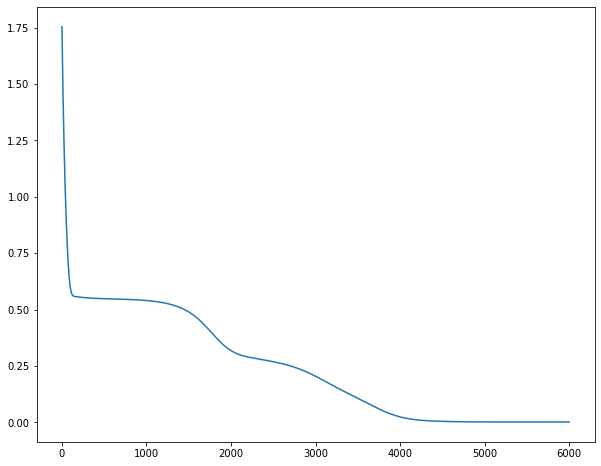

In [ ]:
train_t = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

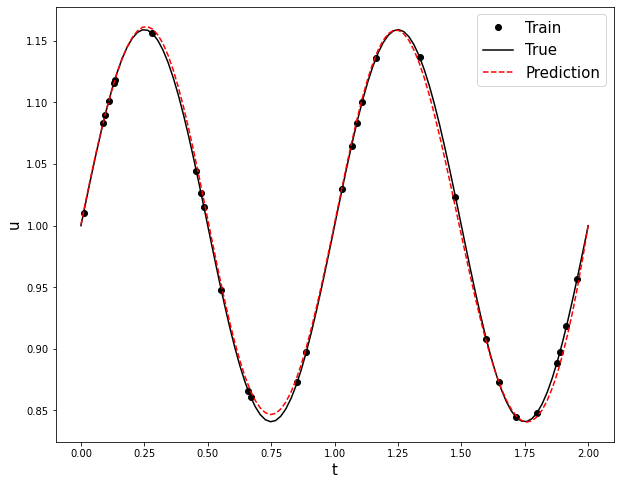

In [ ]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

# 4. Lab 2: Solve Lab 1 Again using DeepXDE

## 4.1. DeepXDE

- Using [DeepXDE](https://deepxde.readthedocs.io/en/latest/) libray
- DeepXDE is a useful library for solving forward and inverse partial differential equations (PDEs) via physics-informed neural network (PINN)

In [ ]:
# !pip install deepxde

- Change DeepXDE backends
    - DeepXDE supports backends for TensorFlow 1.x, TensorFlow 2.x, and PyTorch. We have to change it into TensorFlow 2.x

In [ ]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

Using backend: tensorflow



Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)


## 4.2. Problem Setup Again

- ODE

<br>
$$\frac{du}{dt} = \cos2\pi t$$

- Boundary condition:

<br>
$$u(0) = 1$$

- The exact solution:

<br>
$$u(t) = \frac{1}{2\pi}\sin2\pi t + 1$$

### 4.2.1. Import Library

In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math as m

### 4.2.2. Define ODE System

In [ ]:
pi = tf.constant(m.pi)

def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - tf.math.cos(2*pi*t)

### 4.2.3. Define Initial Condition

In [ ]:
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

### 4.2.4. Define Geometry & Implement Initial Condition

In [ ]:
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

# Reference solution to compute the error
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geom,
                    ode_system,
                    ic,
                    num_domain = 30,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

### 4.2.5. Define Network and Hyper-parameters

In [ ]:
layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

Compiling model...
'compile' took 0.000604 s



### 4.2.6. Train & Prediction

Training model...

Cause: could not parse the source code of <function <lambda> at 0x7fc6d40f8950>: no matching AST found among candidates:
# coding=utf-8
(lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fc6d40f8950>: no matching AST found among candidates:
# coding=utf-8
(lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [5.70e-01, 1.00e+00]    [5.62e-01, 1.00e+00]    []  
1000      [4.61e-01, 5.18e-05]    [4.85e-01, 5.18e-05]    []  
2000      [3.35e-01, 7.91e-07]    [3.43e-01, 7.91e-07]    []  
3000      [1.14e-01, 1.20e-05]    [1.12e-01, 1.20e-05]    []  
4000      [4.74e-03, 2.91e-08]    [3.76e-03, 2.

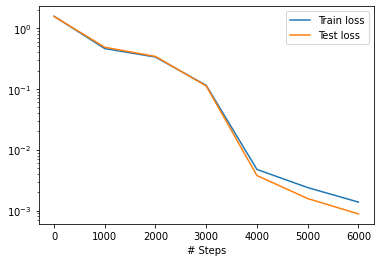

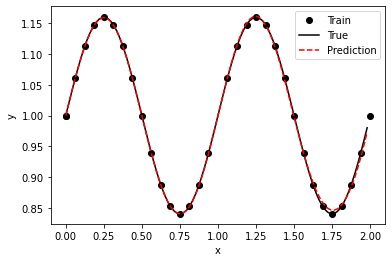

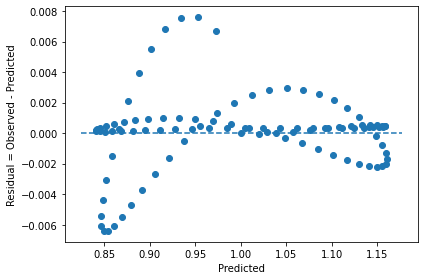

In [ ]:
losshistory, train_state = model.train(epochs = 6000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

# 5. Lab 3: Euler Beam (Solid Mechanics)

## 5.1. Problem Setup

- We will solve a Euler beam problem:



<br>
<center>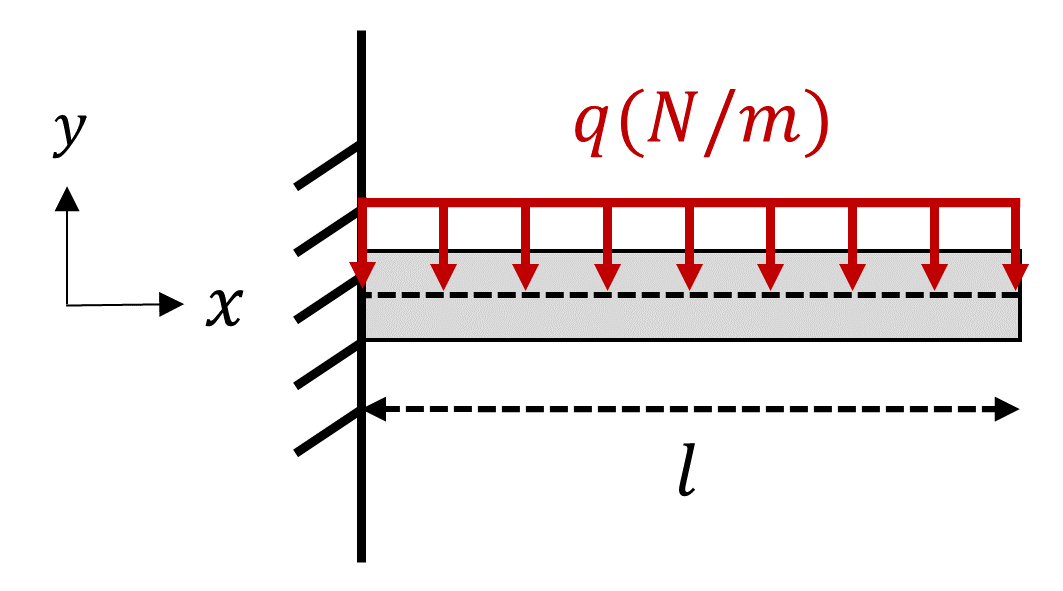</center>
<br>




- Problem properties

$$E = 1 \operatorname{pa}, \quad I = 1 \operatorname{kg\cdot m^2}, \quad q = 1 \operatorname{N/m}, \quad l = 1 \operatorname{m}$$
<br>

- Partial differential equations & boundary conditions

<br>
$${\partial^4 y \over \partial x^4} + 1 = 0,  \qquad \text{where} \quad x \in [0,1]$$
<br>

- One Dirichlet boundary condition on the left boundary:

<br>
$$y(0) = 0$$
<br>

- One Neumann boundary condition on the left boundary:

<br>
$$y'(0) = 0$$
<br>

- Two boundary conditions on the right boundary:

<br>
$$y''(1) = 0, \quad y'''(1) = 0$$
<br>

- The exact solution is

<br>
$$y(x) = -{1 \over 24}x^4 + {1 \over 6}x^3 - {1 \over 4}x^2$$
<br>

- Make a neural network and loss functions like below :


<br><br>
<center>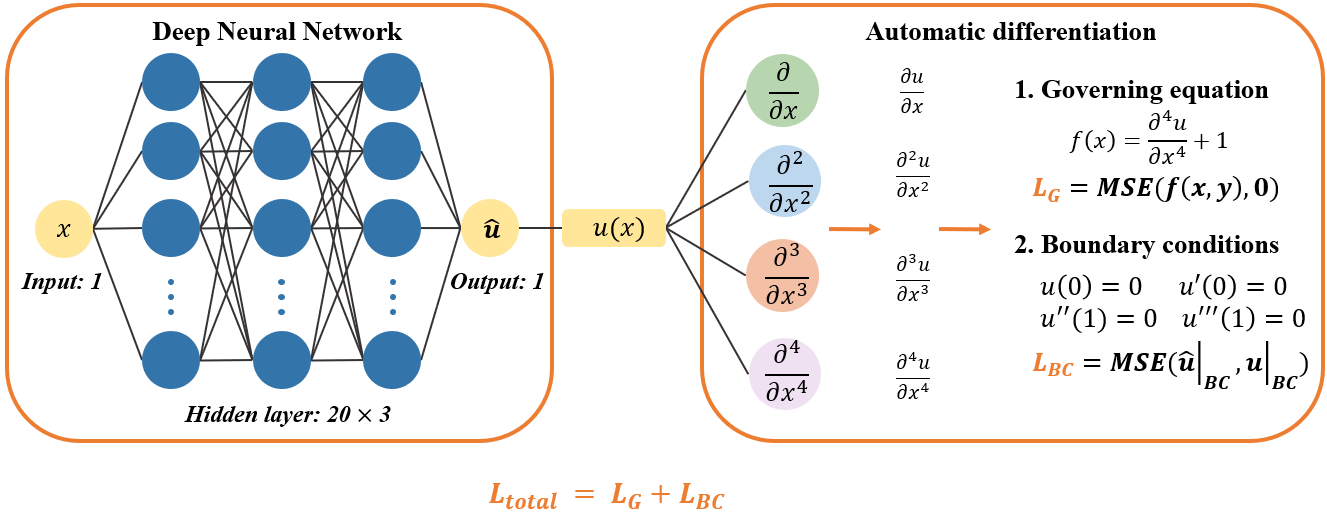</center>
<br>

## 5.2. Solve the Euler Beam problem

### 5.2.1. Import Library

In [ ]:
import deepxde as dde
import numpy as np

### 5.2.2. Define PDE System

In [ ]:
def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1

### 5.2.3. Define Boundary Condition

In [ ]:
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

### 5.2.4. Define Geometry, Implement Boundary Condition

In [ ]:
geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left) # u(0) = 0
bc2 = dde.NeumannBC(geom, lambda x: 0, boundary_left) # u'(0) = 0
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right) # u''(1) = 0
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right) # u'''(1) = 0

# Reference solution to compute the error
def true_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

data = dde.data.PDE(geom,
                    pde,
                    [bc1, bc2, bc3, bc4],
                    num_domain = 10,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

### 5.2.5. Define Network and Hyper-parameters

In [ ]:
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr = 0.001)

Compiling model...
'compile' took 0.001376 s



### 5.2.6. Train & Prediction

Training model...

Cause: could not parse the source code of <function <lambda> at 0x7fc3b3b56170>: no matching AST found among candidates:
# coding=utf-8
(lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fc3b3b56170>: no matching AST found among candidates:
# coding=utf-8
(lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fc3b3b56a70>: no matching AST found among candidates:
# coding=utf-8
(lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at

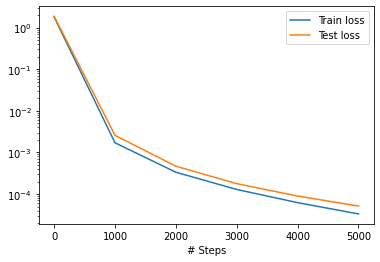

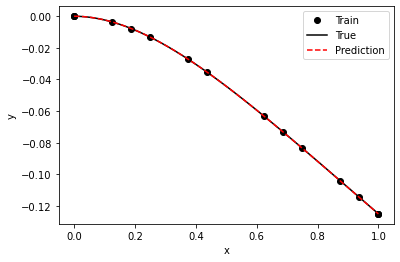

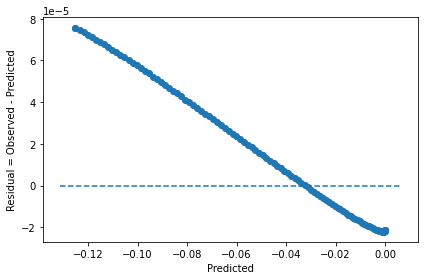

In [ ]:
losshistory, train_state = model.train(epochs = 5000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

# 6. Lab 4: Navier-Stokes Equations (Fluid Mechanics)


- Note: strongly recommend you to use GPU rather than CPU. (you can use CoLab GPU for free)


- If you use Google Colab, please implement below codes

In [ ]:
# !pip install deepxde

In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)


## 6.1. Problem Setup

- We will solve 2D Navier-Stokes Equations to find velocity profile in infinite parallel plates flow
    - Any fluid flowing in plates had to enter at some location. The region of flow near where the fluid enters the plates is termed the _entrance region_ and is illustrated in below figure
    - The fluid typically enters the plates with a nearly uniform velocity profile
    - As the fluid moves through the plates, viscous effects cause it to stick to the plates wall (_no-slip boundary condition_)
    - Thus, a _boundary layer_ is produced along the plates wall such that the initial velocity profile changes with distance along the plates, $x$, until the fluid reaches the end of the hydrodynamic entrance region (which is also called _entrance length_) beyond which the velocity profile does not vary with $x$



<br><br>
<center>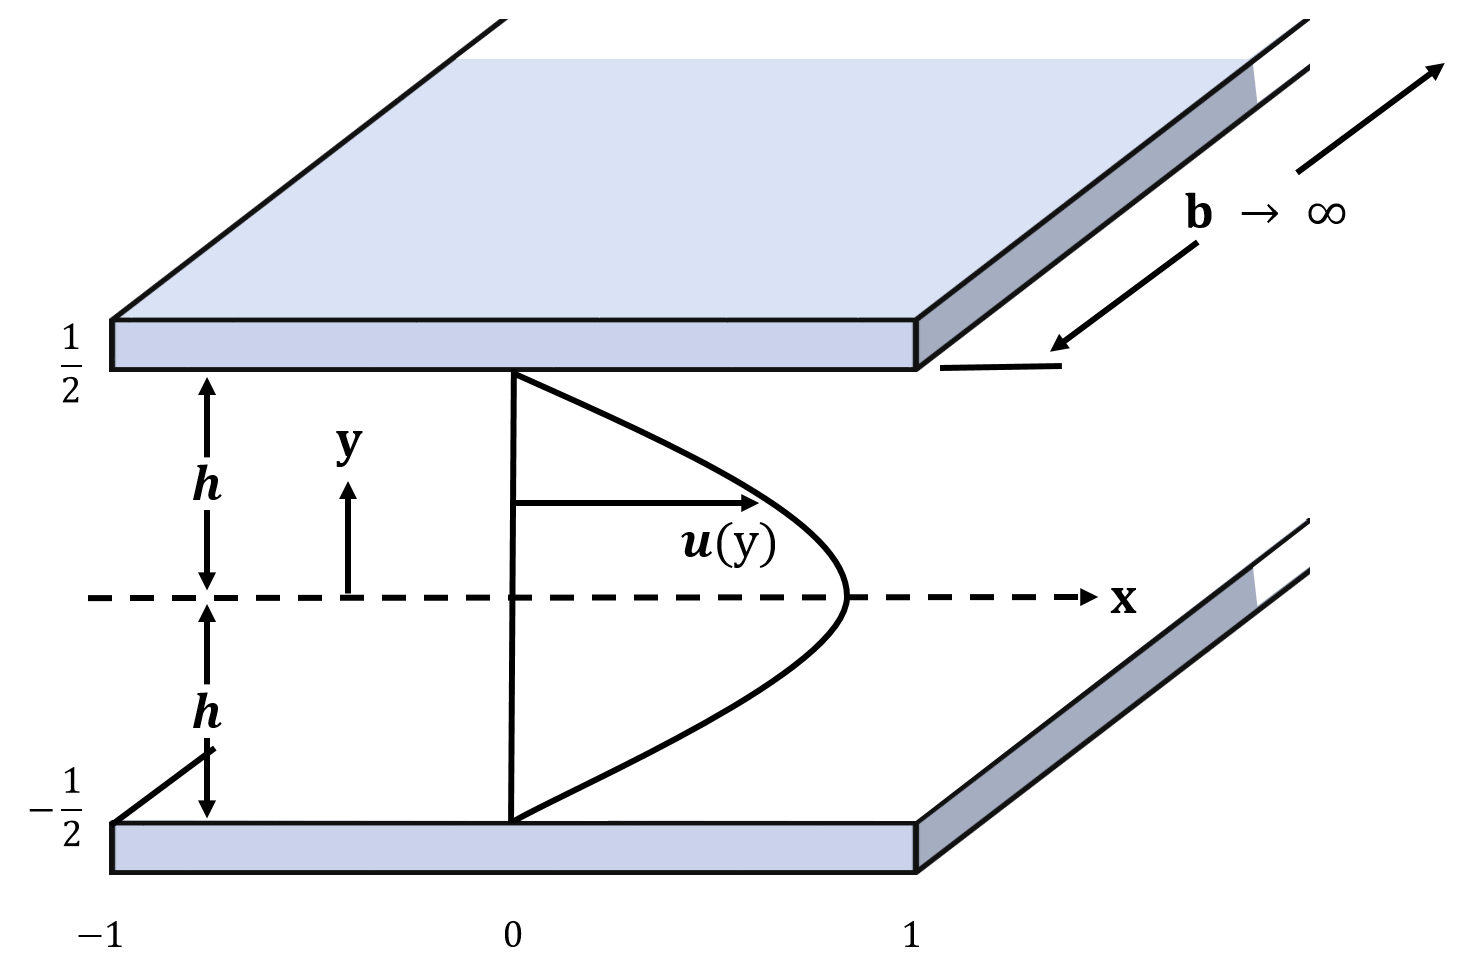</center>
<br><br>




- Problem properties

<br>
$$\rho = 1\operatorname{kg/m^3}, \quad \mu = 1\operatorname{N\cdot s/m^2}, \quad D = 2h = 1\operatorname{m}, \quad
L = 2\operatorname{m}, \quad u_{in} = 1\operatorname{m/s}, \quad \nu = \frac{\mu}{\rho}$$

<br>

- Hydraulic diameter is

<br>
$$\quad D_h = \lim\limits_{b\to\infty} {4(2bh) \over {2b+4h}} = 4h = 2\operatorname{m}$$
<br>

- So, the Reynolds number of this system is

<br>
$$Re = \frac{\rho u_{in} D_h}{\mu} = 2 $$
<br>


- 2D Navier-Stokes Equations & boundary conditions (for steady state)


<br>
$$
\begin{align*}
u{\partial u \over \partial x} + v{\partial u \over \partial y} + {1 \over \rho}{\partial p \over \partial x} - \nu \ \left({\partial^2 u \over {\partial x^2}} + {\partial^2 u \over {\partial y^2}}\right) &= 0\\\\
u{\partial v \over \partial x} + v{\partial v \over \partial y} + {1 \over \rho}{\partial p \over \partial y} - \nu \ \left({\partial^2 v \over {\partial x^2}} + {\partial^2 v \over {\partial y^2}}\right) &= 0\\\\
{\partial u \over \partial x} + {\partial v \over \partial y} &= 0
\end{align*}
$$

<br>

- Two Dirichlet boundary conditions on the plate boundary (no-slip condition),

<br>
$$u(x,y) = 0, \quad v(x,y) = 0 \qquad \text{at} \quad y = \frac{D}{2} \ \; \text{or} \; -\frac{D}{2}$$
<br>

- Two Dirichlet boundary conditions at the inlet boundary

<br>
$$u(-1,y) = u_{\text{in}}, \quad v(-1,y) = 0$$
<br>

- Two Dirichlet boundary conditions at the outlet boundary

<br>
$$p(1,y) = 0, \quad v(1,y) = 0$$
<br>

- Make a neural network and loss functions like below :


<br><br>
<center>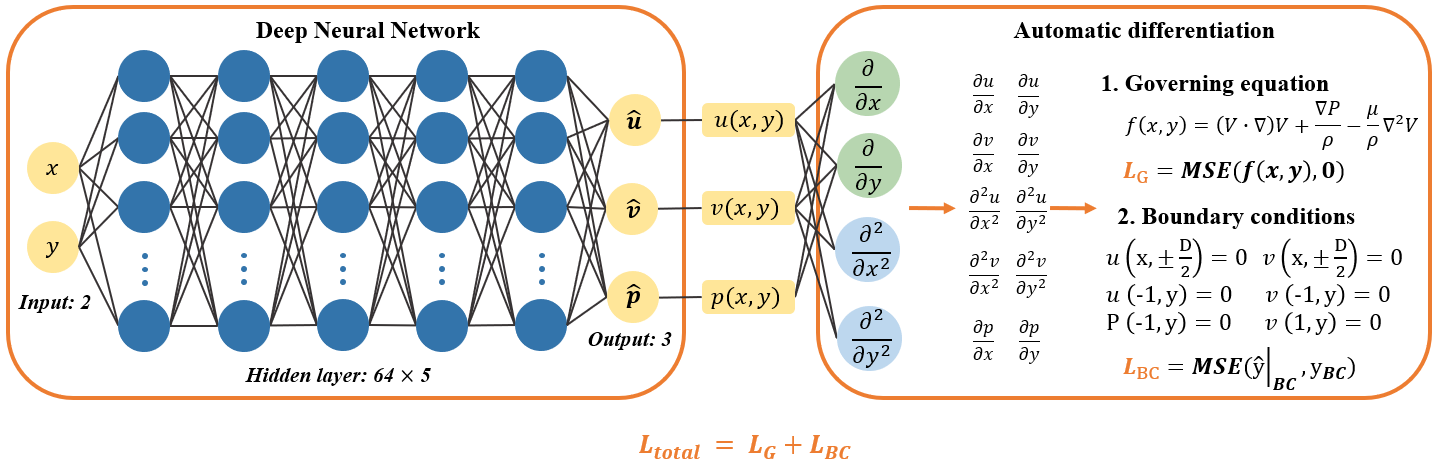</center>
<br>

## 6.2. CFD Solution

- CFD solution of this problem is illustrated in below figures
  - Velocity $u$ and velocity $v$, and pressure $p$, respectively


- Solve this problem using PINN and then compare with CFD solutions
    


<br>
<center>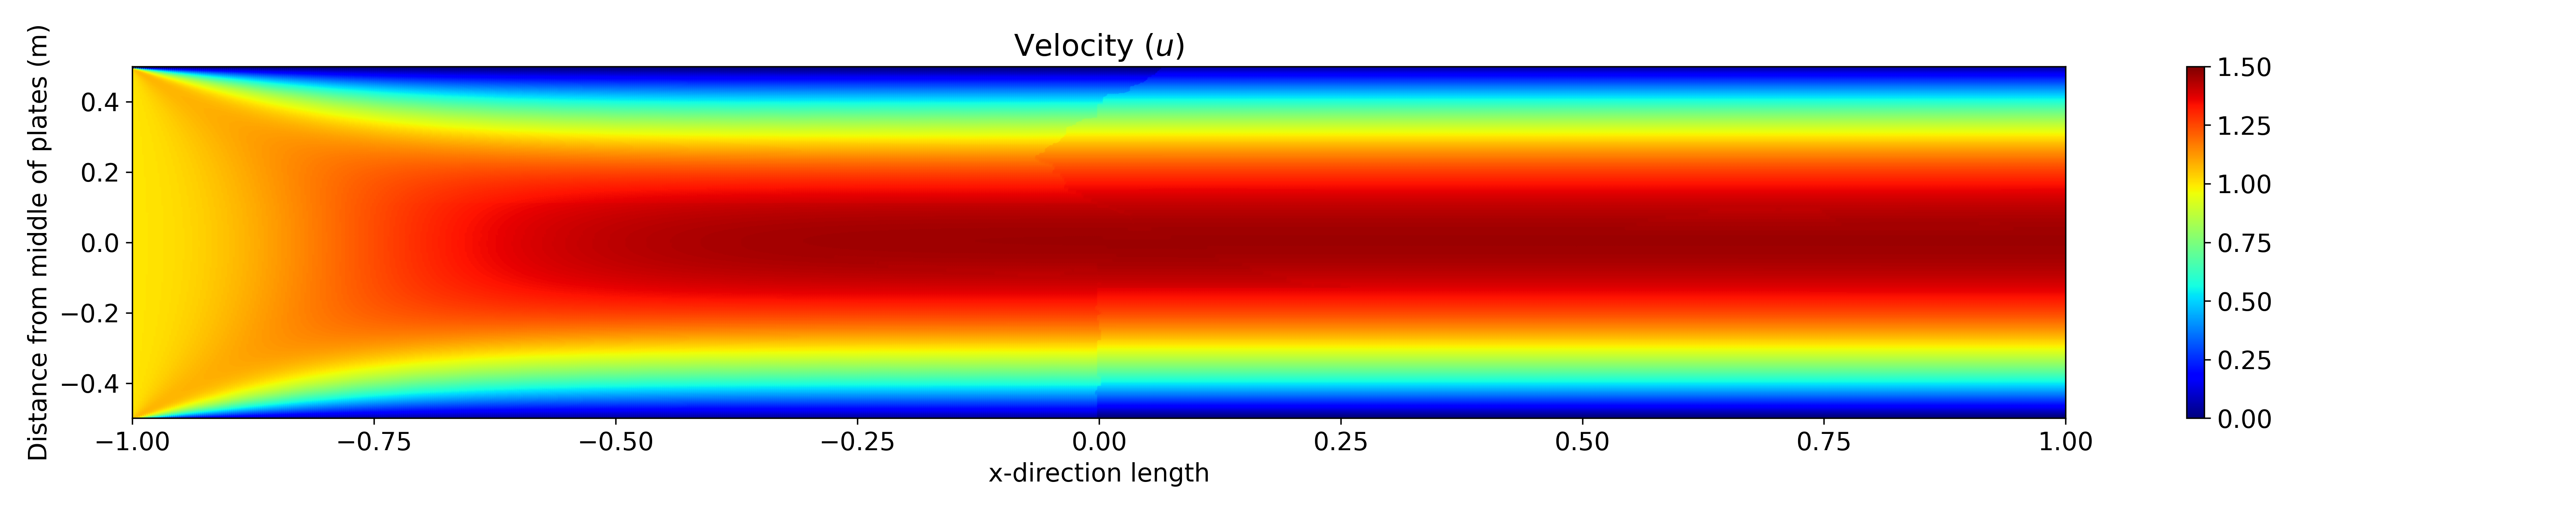</center>
<br>



<br>
<center>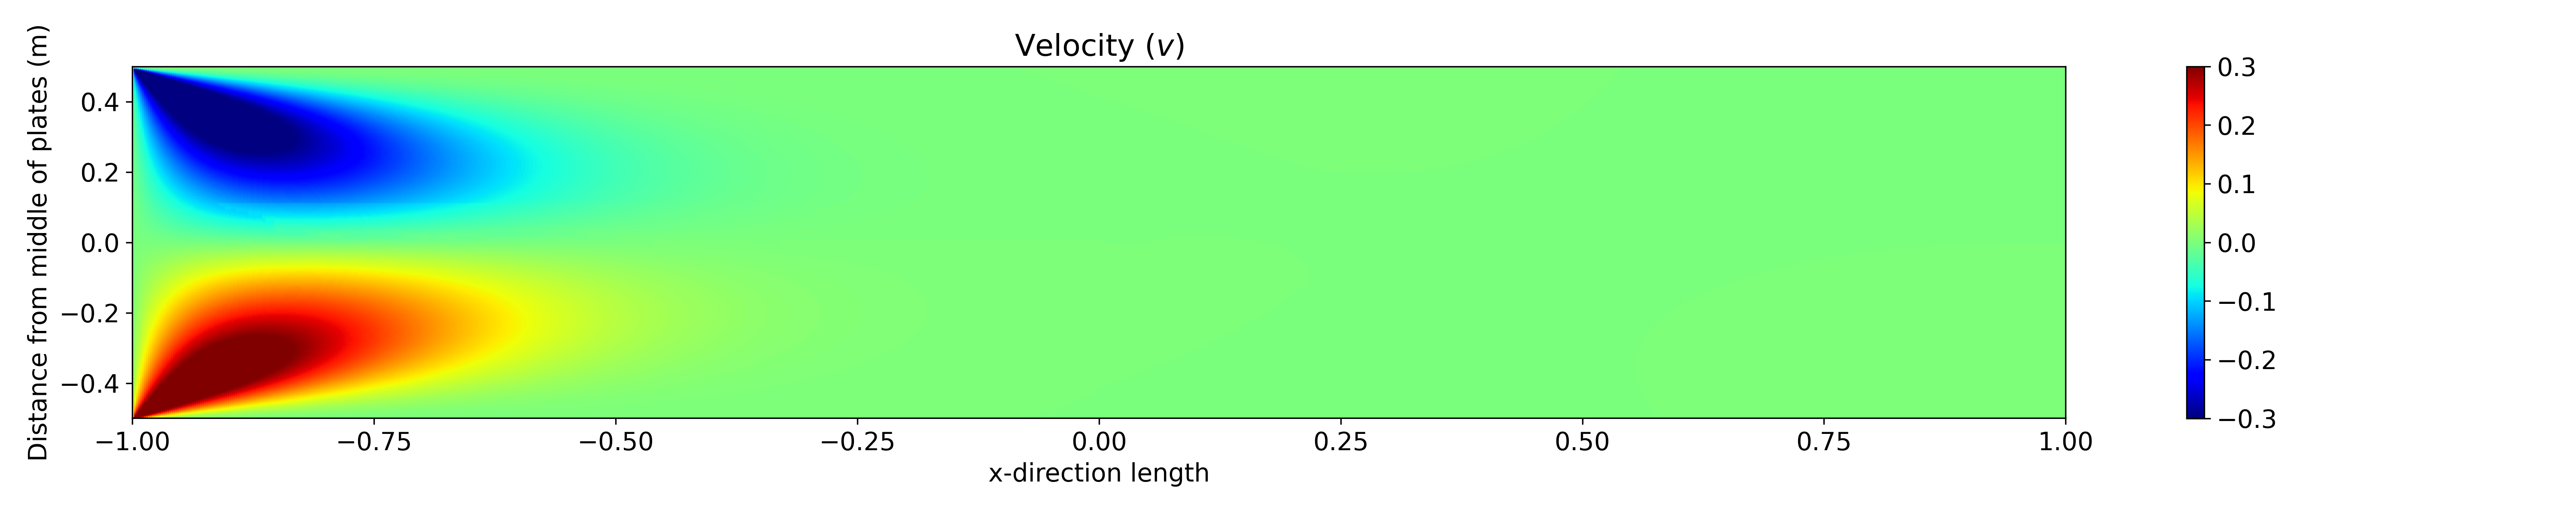</center>
<br>



<br>
<center>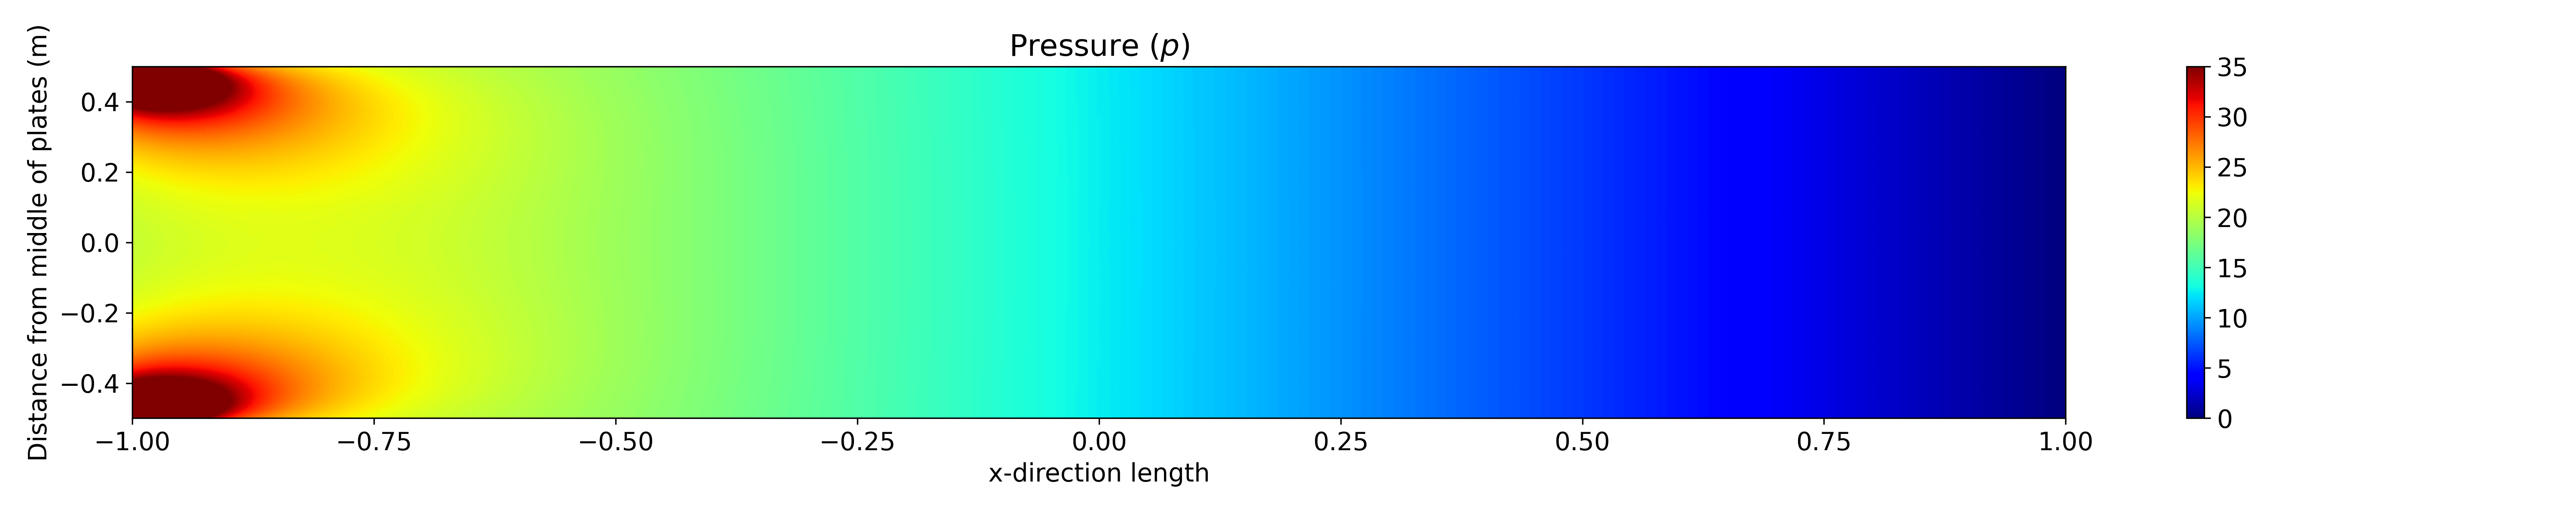</center>
<br>

## 6.3. Solve the Navier-Stokes Equations

### 6.3.1. Define Parameters

In [ ]:
# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

### 6.3.2. Define PDE with Boundary & Initial Conditions

In [ ]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [ ]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

### 6.3.3. Define Geometry, Implement Boundary Condition

In [ ]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 200,
                    num_test = 100)

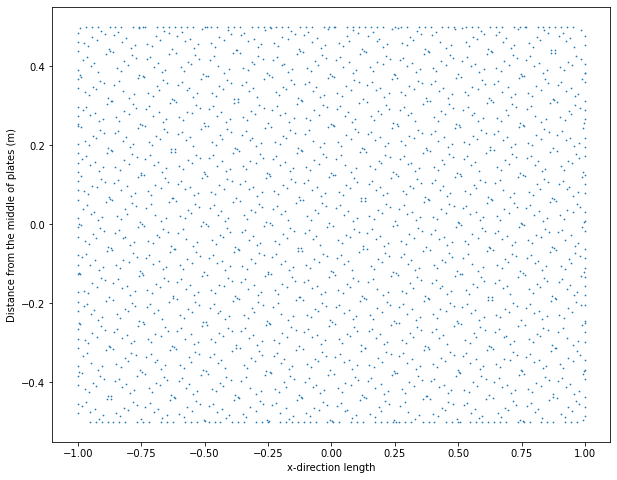

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

### 6.3.4. Define Network and Hyper-parameters

In [ ]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.000917 s



### 6.3.5. Train (Adam Optimizer)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.39e-01, 7.00e-02, 3.06e-02, 1.28e-02, 5.46e-02, 1.07e+00, 1.45e-01, 1.32e-01, 1.45e-01]    [1.45e-01, 6.53e-02, 3.11e-02, 1.28e-02, 5.46e-02, 1.07e+00, 1.45e-01, 1.32e-01, 1.45e-01]    []  
1000      [1.06e-03, 9.03e-04, 9.87e-03, 3.06e-02, 1.77e-02, 3.43e-02, 1.89e-03, 4.28e-04, 4.83e-05]    [6.77e-04, 5.46e-04, 5.30e-03, 3.06e-02, 1.77e-02, 3.43e-02, 1.89e-03, 4.28e-04, 4.83e-05]    []  
2000      [1.45e-03, 6.80e-04, 5.31e-03, 2.26e-02, 1.39e-02, 2.62e-02, 1.44e-03, 1.42e-04, 4.85e-05]    [9.99e-04, 5.48e-04, 3.19e-03, 2.26e-02, 1.39e-02, 2.62e-02, 1.44e-03, 1.42e-04, 4.85e-05]    []  
3000      [6.09e-04, 5.80e-04, 4.42e-03, 1.86e-02, 1.22e-02, 1.89e-02, 3.73e-03, 5.54e-05, 5.93e-06]    [3.23e-04, 2.53e-04, 1.98e-03, 1.86e-02, 1.22e-02, 1.89e-0

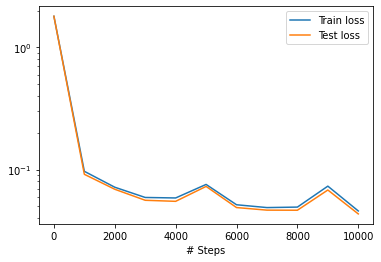

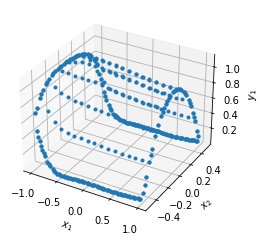

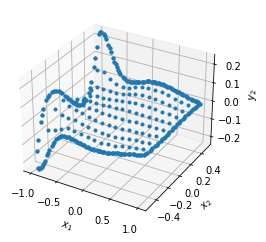

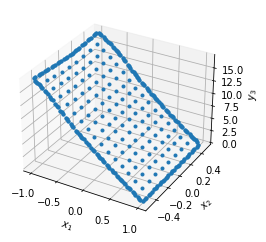

In [ ]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

### 6.3.6. Plot Results (Adam Optimizer)

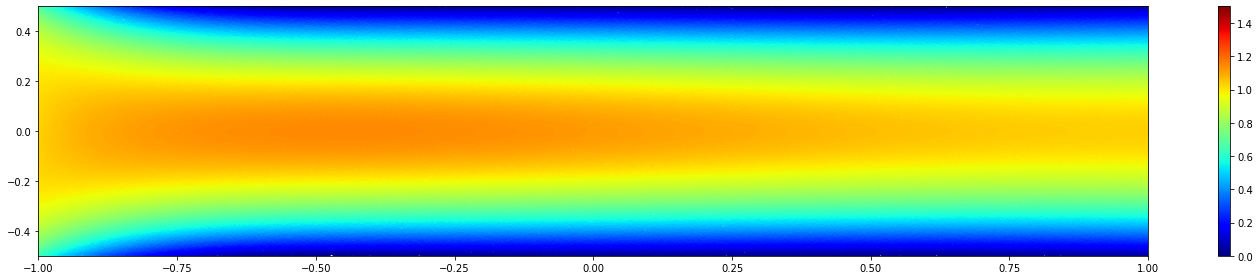

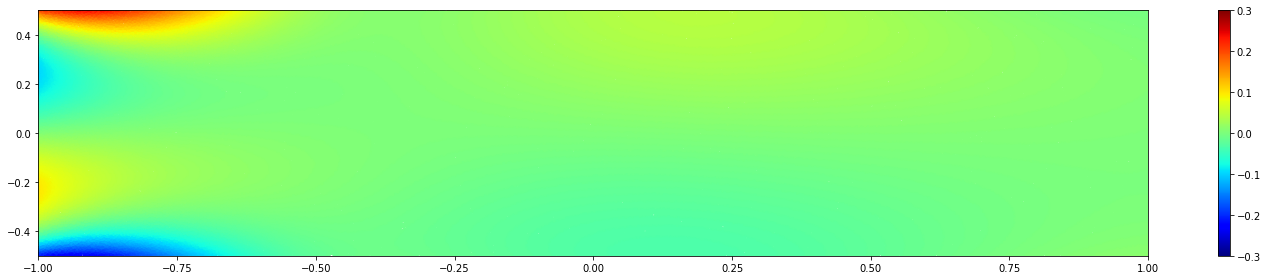

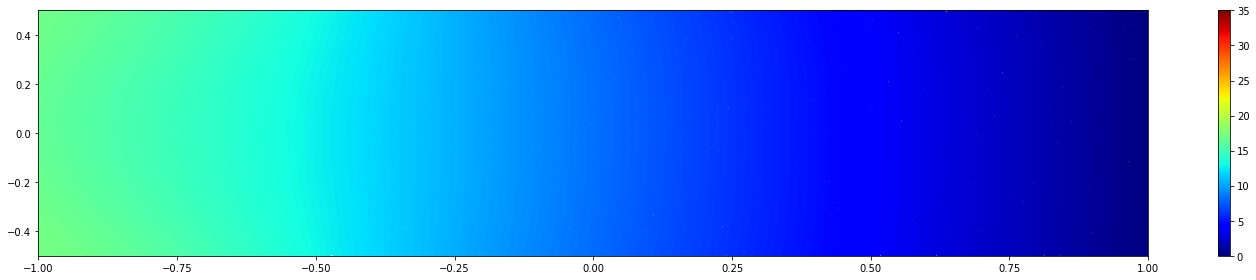

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

### 6.3.7. Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.084066 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [1.34e-03, 7.12e-04, 2.48e-03, 1.50e-02, 6.67e-03, 1.33e-02, 6.20e-03, 1.08e-04, 1.26e-05]    [7.27e-04, 6.22e-04, 6.91e-04, 1.50e-02, 6.67e-03, 1.33e-02, 6.20e-03, 1.08e-04, 1.26e-05]    []  
13000     [3.90e-04, 4.65e-04, 6.08e-04, 2.21e-03, 1.18e-03, 1.01e-03, 1.41e-03, 4.61e-05, 3.93e-06]    [1.91e-04, 2.34e-04, 1.77e-04, 2.21e-03, 1.18e-03, 1.01e-03, 1.41e-03, 4.61e-05, 3.93e-06]    []  

Best model at step 13000:
  train loss: 7.33e-03
  test loss: 6.47e-03
  test metric: []

'train' took 650.417617 s



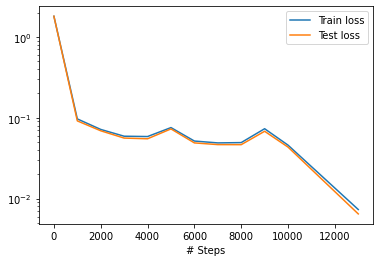

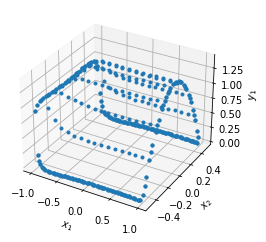

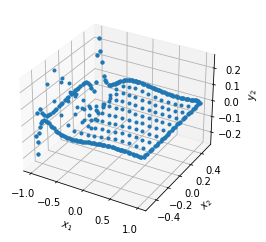

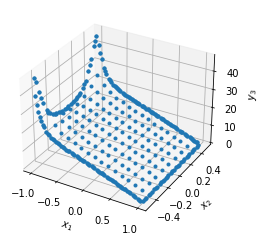

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

### 6.3.8. Plot Results (Adam + L-BFGS)

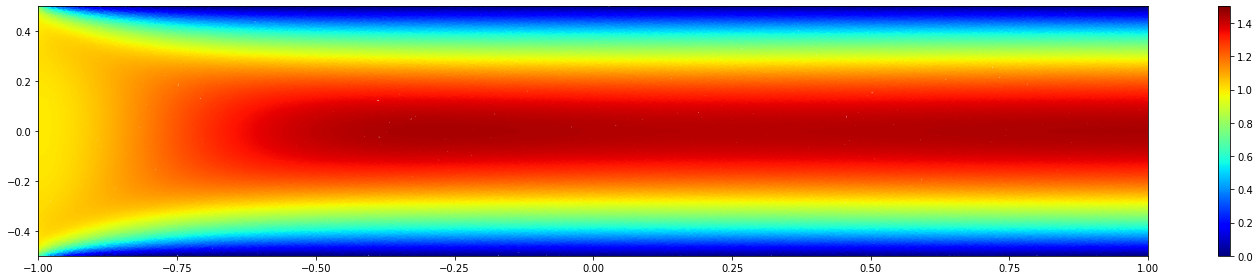

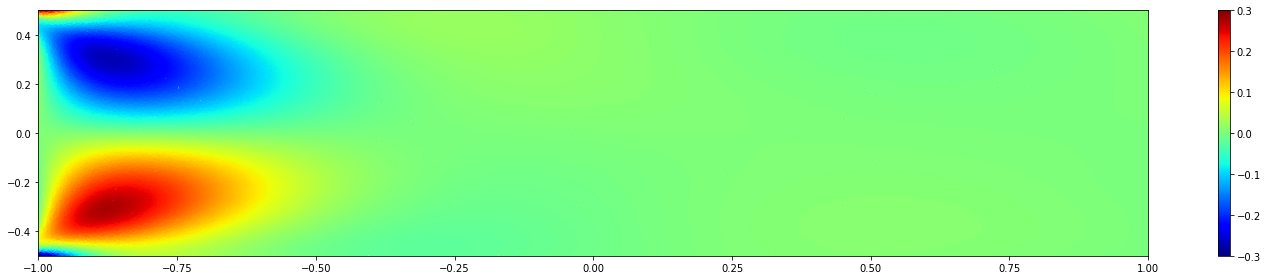

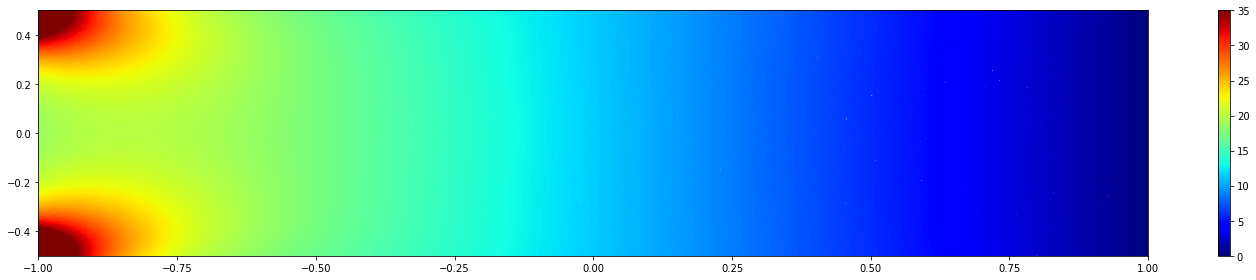

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

### 6.3.9. Validation: Plot Velocity Profile at the End of the Plate

- Fully developed velocity profile at the infinite parallel plates flow are known as

<br>
$$u(y) = {3V_{avg} \over 2} \left[ 1-  \left( \frac{y}{h} \right)^2 \right]$$



<br><br>
<center>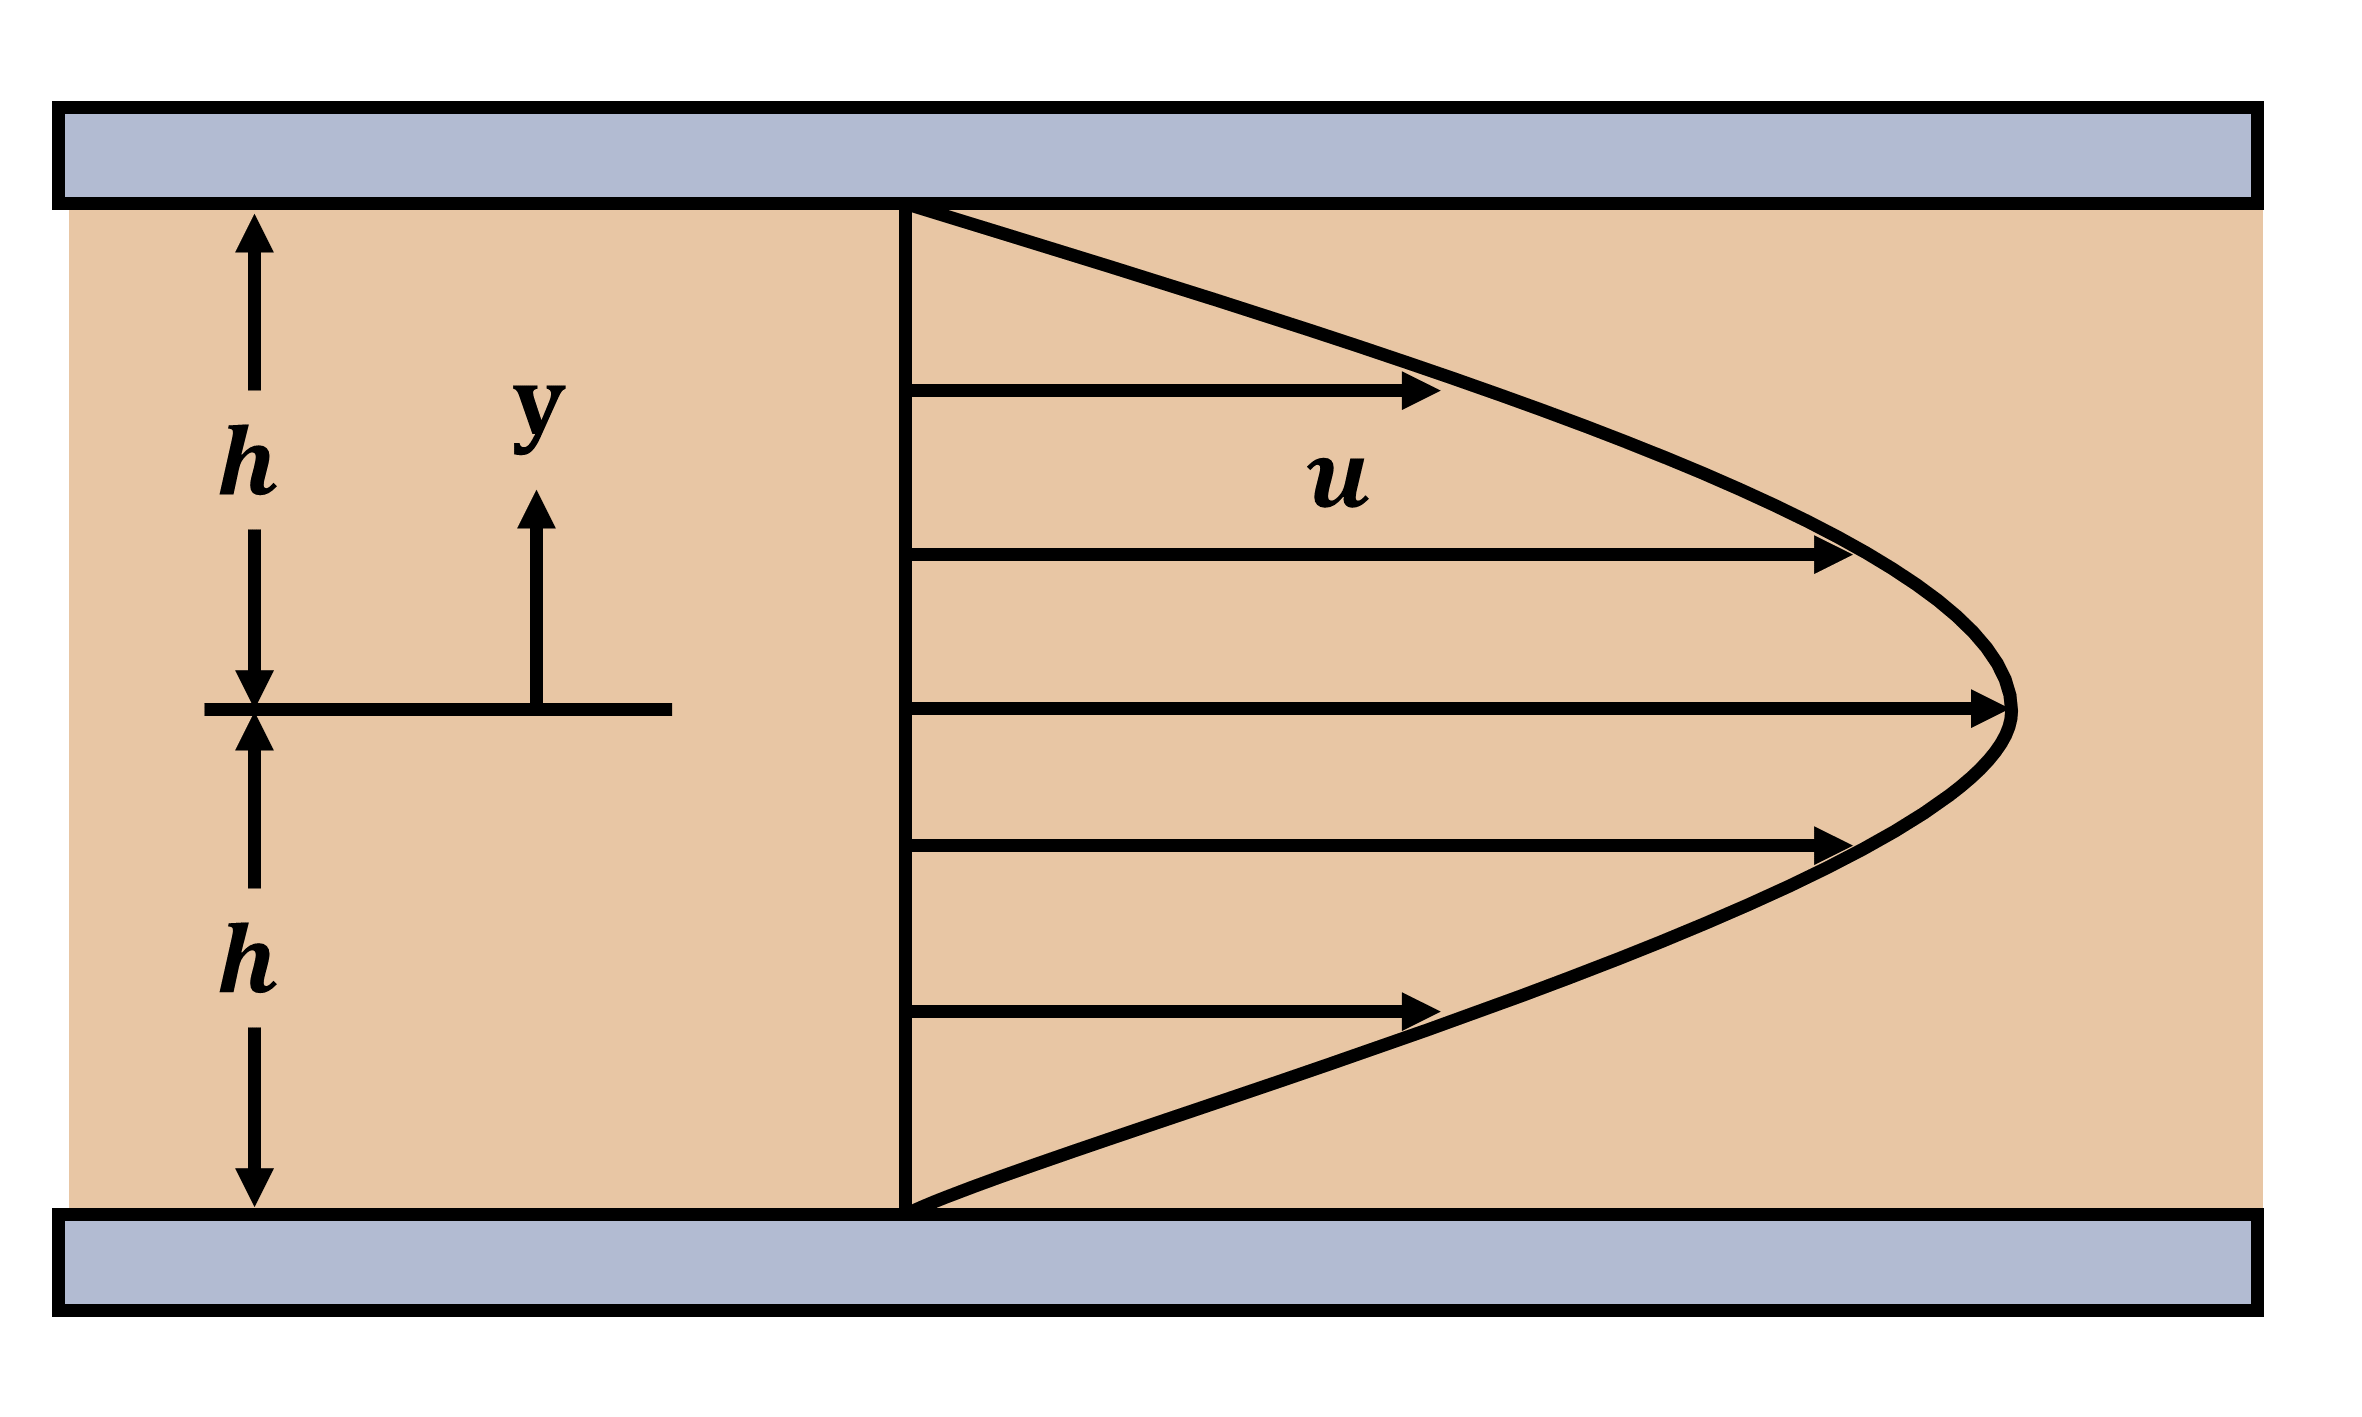</center>
<br>

In [ ]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

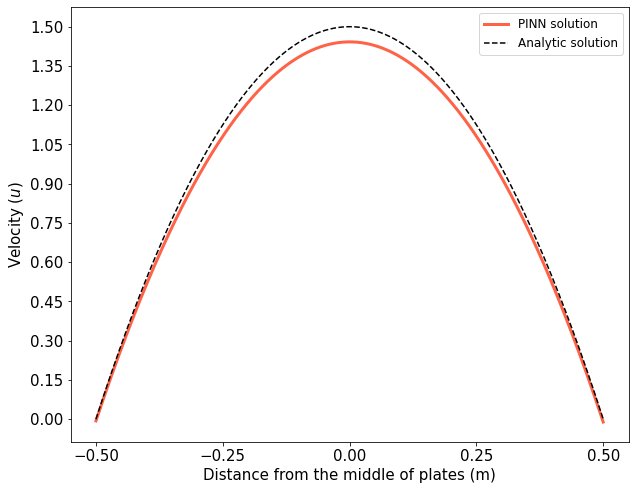

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>